<div class="alert alert-block alert-danger">   
This is not a final solution for this hackathon. But I have included this notebook as it will be a good reference for using fastai for Text Classification problem.
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import os
print(os.listdir("../input"))

['innoplexus_sentiment analysis']


In [2]:
from fastai.text import *
from fastai.imports import *
from fastai.text import *
from fastai import *

In [3]:
path = Path('../input/innoplexus_sentiment analysis/')
path.ls()

[PosixPath('../input/innoplexus_sentiment analysis/test.csv'),
 PosixPath('../input/innoplexus_sentiment analysis/train.csv'),
 PosixPath('../input/innoplexus_sentiment analysis/sample_submission.csv')]

In [4]:
train = pd.read_csv(path/'train.csv')
test = pd.read_csv(path/'test.csv')
sub = pd.read_csv(path/'sample_submission.csv')

In [5]:
train.shape, test.shape

((5279, 4), (2924, 3))

In [6]:
train.drop('unique_hash', axis=1,inplace=True)
test.drop('unique_hash', axis=1, inplace=True)

In [7]:
train.head(2)

,text,drug,sentiment
0,Autoimmune diseases tend to come in clusters. ...,gilenya,2
1,I can completely understand why you’d want to ...,gilenya,2


In [8]:
test.head(2)

,text,drug
0,"256 (previously stable on natalizumab), with 5...",fingolimod
1,On fingolimod and have been since December 201...,fingolimod


In [9]:
np.random.seed(0)

In [10]:
sample = train['text'].loc[0]
sample

'Autoimmune diseases tend to come in clusters. As for Gilenya – if you feel good, don’t think about it, it won’t change anything but waste your time and energy. I’m taking Tysabri and feel amazing, no symptoms (other than dodgy color vision, but I’ve had it since always, so, don’t know) and I don’t know if it will last a month, a year, a decade, ive just decided to enjoy the ride, no point in worrying.'

In [11]:
tokenizer = Tokenizer()
tok = SpacyTokenizer('en')
' '.join(tokenizer.process_text(sample, tok))

'xxmaj autoimmune diseases tend to come in clusters . xxmaj as for xxmaj gilenya – if you feel good , do n’t think about it , it wo n’t change anything but waste your time and energy . i ’m taking xxmaj tysabri and feel amazing , no symptoms ( other than dodgy color vision , but i ’ve had it since always , so , do n’t know ) and i do n’t know if it will last a month , a year , a decade , i ve just decided to enjoy the ride , no point in worrying .'

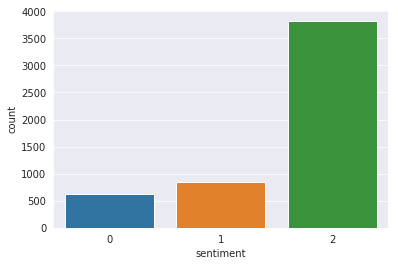

In [12]:
sns.countplot(x='sentiment', data=train)

In [13]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(train, test_size=0.33, random_state=42)

In [14]:
train_df.shape, valid_df.shape

((3536, 3), (1743, 3))

In [15]:
data_lm = TextLMDataBunch.from_df(Path(path), train_df, valid_df, test, text_cols=[0,1], bs=32)
data_clas = TextClasDataBunch.from_df(Path(path), train_df, valid_df, test, text_cols=[0,1], label_cols=2, bs=32)

In [ ]:
data_lm.show_batch()

In [ ]:
data_clas.show_batch()

# Language model

In [16]:
my_fbeta = FBeta(average='macro')

In [17]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5, model_dir='/tmp/model/')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


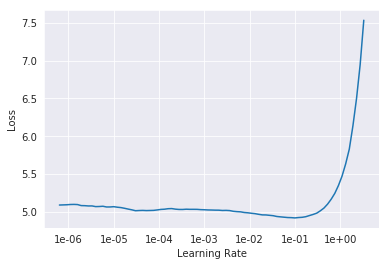

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.001892,3.683338,0.330279,00:59


In [20]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


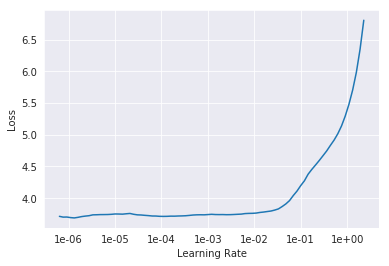

In [21]:
learn.lr_find()
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(9, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.490658,3.526291,0.350781,01:11
1,3.272622,3.397468,0.371210,01:11
2,3.165956,3.289161,0.388217,01:11
3,2.768816,3.203293,0.404345,01:11
4,2.766671,3.145097,0.416015,01:11
5,2.456228,3.127263,0.423715,01:11
6,2.381103,3.121102,0.428286,01:11
7,2.219819,3.127155,0.430035,01:11
8,2.095206,3.133705,0.430157,01:11


In [23]:
learn.save('save_model_1')

In [24]:
TEXT = "I liked "
N_WORDS = 40
N_SENTENCES = 2

In [25]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked  the loading dose and did n’t feel as bad as i wanted . i 've been on Remicade for 19 months and it worked well for me . It only worked for 6 years but it did help
I liked  how your post has not been specifically detailed . My first question is how much have you experienced on the use of Humira and how it 's working ? As my mother was on Humira for


In [26]:
learn.save_encoder('save_model_1_enc')

# Classifier

In [27]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.4, model_dir='/tmp/model/', metrics = [accuracy, my_fbeta])
learn.load_encoder('save_model_1_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


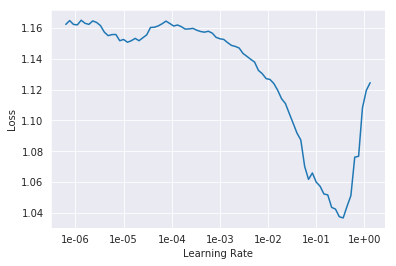

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.751326,0.700101,0.729776,0.329303,00:54


In [30]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.724551,0.681526,0.736661,0.369117,00:53


In [31]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.674675,0.680838,0.738956,0.435832,00:56


In [32]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.546415,0.669759,0.738382,0.414439,01:06
1,0.518547,0.691454,0.735514,0.461064,01:04
2,0.424212,0.713625,0.723465,0.484590,01:16
3,0.341157,0.735729,0.728055,0.486887,01:23
4,0.308714,0.752355,0.711991,0.502826,01:18


In [ ]:
#print(learn)

In [33]:
learn.predict("I really loved the flight")

(Category 2, tensor(2), tensor([0.0128, 0.0202, 0.9670]))

# Predict on test set

In [34]:
log_preds, test_labels = learn.get_preds(ds_type=DatasetType.Test, ordered=True)

In [35]:
preds = np.argmax(log_preds, 1)
preds

tensor([2, 2, 2,  ..., 2, 2, 2])

In [36]:
len(preds)

2924

# Submission

In [37]:
test_df = pd.read_csv('../input/innoplexus_sentiment analysis/test.csv', usecols=['unique_hash'])
test_df.head()

,unique_hash
0,9e9a8166b84114aca147bf409f6f956635034c08
1,e747e6822c867571afe7b907b51f0f2ca67b0e1a
2,50b6d851bcff4f35afe354937949e9948975adf7
3,7f82ec2176ae6ab0b5d20b5ffc767ac829f384ae
4,8b37d169dee5bdae27060949242fb54feb6a7f7f


In [38]:
test_df['sentiment'] = preds
test_df.head()

,unique_hash,sentiment
0,9e9a8166b84114aca147bf409f6f956635034c08,2
1,e747e6822c867571afe7b907b51f0f2ca67b0e1a,2
2,50b6d851bcff4f35afe354937949e9948975adf7,2
3,7f82ec2176ae6ab0b5d20b5ffc767ac829f384ae,2
4,8b37d169dee5bdae27060949242fb54feb6a7f7f,2


In [39]:
test_df['sentiment'].value_counts()

2    2424
1     277
0     223
Name: sentiment, dtype: int64

In [40]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

def create_download_link(df, title = "Download CSV file", filename = "submission.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(test_df)